In [1]:
import git
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# load data from compare-models notebook
episodes = pd.read_pickle("episodes.pkl")

episodes = episodes.assign(
    protocol=pd.Categorical(
        episodes.protocol,
        categories=sorted(set(episodes.protocol), key=lambda x: x != "nakamoto"),
    )
)
episodes = episodes.assign(
    kind=pd.Categorical(episodes.kind, categories=["trained", "hard-coded"])
)
columns = list(episodes.columns)
columns.remove("family")
columns.insert(1, "family")
episodes = episodes[columns]
episodes = episodes.assign(
    episode_relrew=lambda d: d.episode_reward_attacker
    / (d.episode_reward_attacker + d.episode_reward_defender),
    episode_rpp=lambda d: d.episode_reward_attacker / d.episode_progress,
)
list(episodes.columns)

['protocol',
 'family',
 'k',
 'reward',
 'subblock_selection',
 'alpha',
 'gamma',
 'batch',
 'learning_rate',
 'ent_coef',
 'shape',
 'policy',
 'path',
 'kind',
 'reuse',
 'reused',
 'episode',
 'episode_reward_attacker',
 'episode_reward_defender',
 'episode_progress',
 'episode_chain_time',
 'episode_sim_time',
 'episode_n_steps',
 'episode_n_activations',
 'episode_relrew',
 'episode_rpp']

In [3]:
dict(
    alpha=episodes.alpha.drop_duplicates().sort_values().tolist(),
    gamma=episodes.gamma.drop_duplicates().sort_values().tolist(),
    kind=episodes.kind.drop_duplicates().sort_values().tolist(),
    reuse=episodes.reuse.drop_duplicates().sort_values().tolist(),
    n_episodes=len(episodes.episode.drop_duplicates()),
    n_models=len(episodes.path.drop_duplicates()) - 1,  # minus 1 for NaN
)

{'alpha': [0.25, 0.3, 0.35, 0.4, 0.45],
 'gamma': [0.05, 0.5, 0.95],
 'kind': ['trained', 'hard-coded'],
 'reuse': ['-',
  'alpha25',
  'alpha30',
  'alpha35',
  'alpha40',
  'alpha45',
  'gamma5',
  'gamma95'],
 'n_episodes': 100,
 'n_models': 360}

In [4]:
setting_key = [
    "protocol",
    "family",
    "k",
    "reward",
    "subblock_selection",
    "alpha",
    "gamma",
]
settings = (
    episodes[setting_key]
    .drop_duplicates()
    .sort_values(setting_key)
    .reset_index(drop=True)
)
settings

,protocol,family,k,reward,subblock_selection,alpha,gamma
0,spar-8,spar,8,constant,n/a,0.25,0.05
1,spar-8,spar,8,constant,n/a,0.25,0.50
2,spar-8,spar,8,constant,n/a,0.25,0.95
3,spar-8,spar,8,constant,n/a,0.30,0.05
4,spar-8,spar,8,constant,n/a,0.30,0.50
5,spar-8,spar,8,constant,n/a,0.30,0.95
6,spar-8,spar,8,constant,n/a,0.35,0.05
7,spar-8,spar,8,constant,n/a,0.35,0.50
8,spar-8,spar,8,constant,n/a,0.35,0.95
9,spar-8,spar,8,constant,n/a,0.40,0.05


In [5]:
trained_episodes = (
    # episodes.query('kind == "trained" or (family in ["nakamoto", "tailstorm"])')
    episodes.sort_values(setting_key).reset_index(drop=True)
)
trained_episodes[setting_key + ["policy"]]

,protocol,family,k,reward,subblock_selection,alpha,gamma,policy
0,spar-8,spar,8,constant,n/a,0.25,0.05,ppo-xkz7k27q-last
1,spar-8,spar,8,constant,n/a,0.25,0.05,ppo-xkz7k27q-best
2,spar-8,spar,8,constant,n/a,0.25,0.05,ppo-7la8u40p-last
3,spar-8,spar,8,constant,n/a,0.25,0.05,ppo-7la8u40p-best
4,spar-8,spar,8,constant,n/a,0.25,0.05,ppo-l1hvnp7p-last
...,...,...,...,...,...,...,...,...
147595,sdag-8-discount,sdag,8,discount,heuristic,0.45,0.95,minor-delay
147596,sdag-8-discount,sdag,8,discount,heuristic,0.45,0.95,override-catchup
147597,sdag-8-discount,sdag,8,discount,heuristic,0.45,0.95,override-block
147598,sdag-8-discount,sdag,8,discount,heuristic,0.45,0.95,release-block


In [6]:
model_key = setting_key + ["policy", "kind"]
models = (
    trained_episodes.groupby(model_key, observed=True)
    .agg(
        n=("episode", len),
        relrew_mean=("episode_relrew", np.mean),
        relrew_std=("episode_relrew", np.std),
        rpp_mean=("episode_rpp", np.mean),
        rpp_std=("episode_rpp", np.std),
    )
    .reset_index()
)
models

/tmp/ipykernel_32325/724410382.py:3: FutureWarning: The provided callable <function mean at 0x7f97a0759310> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  trained_episodes.groupby(model_key, observed=True)
/tmp/ipykernel_32325/724410382.py:3: FutureWarning: The provided callable <function std at 0x7f97a0759430> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  trained_episodes.groupby(model_key, observed=True)


,protocol,family,k,reward,subblock_selection,alpha,gamma,policy,kind,n,relrew_mean,relrew_std,rpp_mean,rpp_std
0,spar-8,spar,8,constant,n/a,0.25,0.05,honest,hard-coded,100,0.250830,0.010405,0.250830,0.010405
1,spar-8,spar,8,constant,n/a,0.25,0.05,ppo-2wjkcslh-best,trained,100,0.248737,0.008760,0.248737,0.008760
2,spar-8,spar,8,constant,n/a,0.25,0.05,ppo-2wjkcslh-last,trained,100,0.249409,0.008924,0.249409,0.008924
3,spar-8,spar,8,constant,n/a,0.25,0.05,ppo-3mztxalz-best,trained,100,0.249427,0.008781,0.249427,0.008781
4,spar-8,spar,8,constant,n/a,0.25,0.05,ppo-3mztxalz-last,trained,100,0.249878,0.009375,0.249878,0.009375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1471,sdag-8-discount,sdag,8,discount,heuristic,0.45,0.95,ppo-v0e3lcie-best,trained,100,0.470599,0.012263,0.470181,0.012221
1472,sdag-8-discount,sdag,8,discount,heuristic,0.45,0.95,ppo-v0e3lcie-last,trained,100,0.471464,0.012925,0.466276,0.012812
1473,sdag-8-discount,sdag,8,discount,heuristic,0.45,0.95,ppo-vw8609oz-best,trained,100,0.470488,0.034146,0.456392,0.033430
1474,sdag-8-discount,sdag,8,discount,heuristic,0.45,0.95,ppo-vw8609oz-last,trained,100,0.094069,0.040549,0.091725,0.039232


In [7]:
best_models = models.loc[
    models.groupby(setting_key + ["kind"], observed=True).rpp_mean.idxmax()
]
best_models_episodes = pd.merge(
    best_models[model_key], episodes, on=model_key, how="left"
)

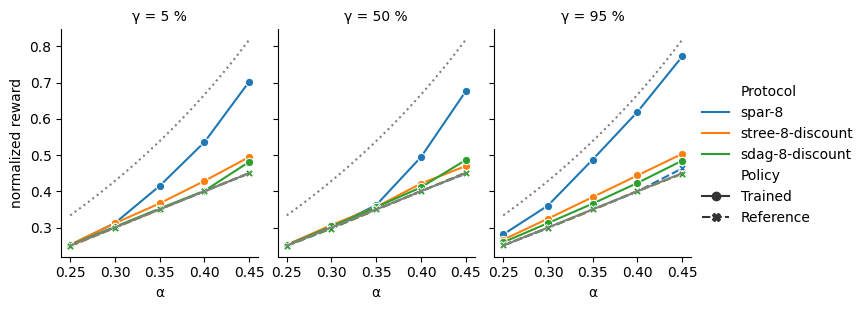

In [8]:
# Some renaming for the paper
def humProtocol(x):
    if x == "nakamoto":
        return "Bitcoin"
    if x == "tailstorm-8-discount":
        return "Tailstorm"
    if x == "tailstorm-8-constant":
        return "TS/const"
    if x == "bk-8":
        return "Bₖ"
    return x


def humPolicy(x):
    if x == "trained":
        return "Trained"
    if x == "hard-coded":
        return "Reference"
    return x


subset = best_models.copy()
subset["Protocol"] = subset.protocol.map(humProtocol)
subset.Protocol = pd.Categorical(
    subset.Protocol  # , categories=["Bitcoin", "TS/const", "Tailstorm", "Bₖ"]
)
subset["Policy"] = subset.kind.map(humPolicy)
subset.Policy = pd.Categorical(subset.Policy, categories=["Trained", "Reference"])
subset["γ"] = subset.gamma.map(lambda x: f"{x * 100:g} %")
subset["α"] = subset.alpha

fig = sns.relplot(
    kind="line",
    data=subset,
    y="rpp_mean",
    x="α",
    col="γ",
    hue="Protocol",
    style="Policy",
    markers=True,
    height=3.2,
    aspect=0.75,
)
fig.set(ylabel="normalized reward")
for ax in fig.axes.flatten():
    alpha = np.linspace(min(best_models.alpha), max(best_models.alpha), 20)
    ax.plot(alpha, alpha, linestyle="solid", color="gray")
    ax.plot(alpha, alpha / (1 - alpha), linestyle="dotted", color="gray")
    # ax.set_xticks(subset.alpha.drop_duplicates(), labels=subset.alpha.drop_duplicates(), rotation=30)
    ax.set_xticks(subset.alpha.drop_duplicates())


fig.savefig(
    "reward_per_progress_rl.png",
    dpi=600,
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
)

In [9]:
# Build and export wide CSV table for pgfplots
def texProtocol(x):
    if x.family == "nakamoto":
        return "seq"
    if x.family == "tailstorm":
        return f"ts{x.k}{x.reward[0]}"
    if x.family in ["spar", "sdag", "stree"]:
        return f"{x.family[1:]}{x.k}{x.reward[0]}"
    if x.family == "bk":
        return f"bk{x.k}"
    assert False


def texPolicy(x):
    if x == "trained":
        return "rl"
    if x == "hard-coded":
        return "hc"
    assert False


subset = best_models.copy()
subset["protocol"] = subset.apply(texProtocol, axis=1)
subset["policy"] = subset.kind.map(texPolicy)
subset["gamma"] = subset.gamma.map(lambda x: f"gamma{int(x * 100):02d}")
wide = subset.pivot(
    index="alpha", columns=["gamma", "protocol", "policy"], values="rpp_mean"
)
wide.columns = ["_".join(col) for col in wide.columns.values]
wide.to_csv("rl-results.csv")
wide

,gamma05_par8c_rl,gamma05_par8c_hc,gamma50_par8c_rl,gamma50_par8c_hc,gamma95_par8c_rl,gamma95_par8c_hc,gamma05_tree8d_rl,gamma05_tree8d_hc,gamma50_tree8d_rl,gamma50_tree8d_hc,gamma95_tree8d_rl,gamma95_tree8d_hc,gamma05_dag8d_rl,gamma05_dag8d_hc,gamma50_dag8d_rl,gamma50_dag8d_hc,gamma95_dag8d_rl,gamma95_dag8d_hc
alpha,,,,,,,,,,,,,,,,,,
0.25,0.251984,0.250830,0.250901,0.249722,0.280811,0.250732,0.252703,0.247915,0.252363,0.249600,0.266268,0.251016,0.251574,0.250015,0.251377,0.249346,0.259177,0.250493
0.30,0.312331,0.300625,0.300898,0.299580,0.360537,0.298359,0.311835,0.299328,0.306818,0.298664,0.324404,0.299136,0.301890,0.299346,0.303160,0.297046,0.312239,0.299033
0.35,0.414855,0.350894,0.361869,0.348633,0.487567,0.348930,0.366695,0.349365,0.356601,0.348540,0.383935,0.347881,0.352271,0.350879,0.356303,0.349756,0.365880,0.349785
0.40,0.535650,0.399849,0.494368,0.400832,0.619078,0.399995,0.428538,0.400771,0.421358,0.400269,0.443778,0.401496,0.401265,0.400107,0.410755,0.399478,0.422990,0.399687
0.45,0.702562,0.450210,0.675823,0.448289,0.771836,0.463002,0.494608,0.449846,0.469520,0.451279,0.503344,0.447664,0.481151,0.449346,0.486215,0.451230,0.484488,0.448740
